# Next Word Prediction with LSTMs

This notebook walks through the complete process of building and training a neural network to predict the next word, based on a given text corpus. This project fulfills all the requirements outlined in the PDF, using 'The Adventures of Sherlock Holmes' (`book.txt`) as our training data.

We will cover:
1.  **Setup and Imports**
2.  **Data Collection & Loading**
3.  **Reading and Preprocessing Text**
4.  **Exploratory Data Analysis (EDA)**
5.  **Preparing Training Data (Sequencing)**
6.  **Encoding the Data**
7.  **Building the Neural Network (LSTM)**
8.  **Training the Model**
9.  **Model Evaluation**
10. **Testing with Custom Input**
11. **Experimentation & Next Steps**

## 1. Setup and Imports

First, let's import all the necessary libraries. We'll need core data science libraries, `nltk` for some text processing, and `tensorflow.keras` for building our deep learning model.

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
from collections import Counter

# NLTK for text processing (like bigrams)
import nltk
from nltk import bigrams
# We don't need the full 'punkt' for this guide, as we split on spaces
# but it's good practice if you were doing sentence tokenization.
# nltk.download('punkt')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set a nice style for plots
sns.set_style("whitegrid")

## 2. Data Collection

The project requires a text corpus. We will use the provided `book.txt` file ('The Adventures of Sherlock Holmes').

In [2]:
!wget -O book.txt 'https://raw.githubusercontent.com/ChetanParmarHQ/Next-Word-Prediction-with-LSTMs/refs/heads/main/book.txt'

FILE_PATH = "book.txt"

# Check if the file exists
if not os.path.exists(FILE_PATH):
  print("Error: book.txt not found. Please make sure it's in the same directory.")
else:
  print(f"Training data found: {FILE_PATH}")

--2025-11-12 05:56:15--  https://raw.githubusercontent.com/ChetanParmarHQ/Next-Word-Prediction-with-LSTMs/refs/heads/main/book.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595481 (582K) [text/plain]
Saving to: ‘book.txt’

book.txt            100%[===================>] 581.52K  --.-KB/s    in 0.04s   

2025-11-12 05:56:16 (13.1 MB/s) - ‘book.txt’ saved [595481/595481]

Training data found: book.txt


## 3. Reading and Preprocessing Text

Now, we'll read the text and clean it. This fulfills the requirements:
* Reading the file.
* Removing Project Gutenberg headers/footers (a good practice for these texts).
* Converting to lowercase.
* Removing punctuation, numbers, and other non-alphabetic characters.
* Splitting the text into a list of words.

In [3]:
def load_and_clean_text(file_path):
    # Read text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Remove Gutenberg headers/footers
    start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK"
    end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK"
    start_index = text.find(start_marker)
    end_index = text.find(end_marker)

    if start_index != -1 and end_index != -1:
        text = text[start_index + len(start_marker) : end_index]

    # Clean text - lowercase, remove punctuation/numbers
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with one

    # Split into words
    words = text.split()

    print(f"Total words found (after cleaning): {len(words)}")
    return words

words = load_and_clean_text(FILE_PATH)
print(f"\nFirst 100 words: \n{' '.join(words[:100])}")

Total words found (after cleaning): 104407

First 100 words: 
the adventures of sherlock holmes produced by an anonymous project gutenberg volunteer and jose menendez cover the adventures of sherlock holmes by arthur conan doyle contents i a scandal in bohemia ii the redheaded league iii a case of identity iv the boscombe valley mystery v the five orange pips vi the man with the twisted lip vii the adventure of the blue carbuncle viii the adventure of the speckled band ix the adventure of the engineers thumb x the adventure of the noble bachelor xi the adventure of the beryl coronet xii the adventure of the copper beeches i


## 4. Exploratory Data Analysis (EDA)

As required, let's explore our data to understand it better. We'll look at:
1.  **Most Frequent Words:** To see common words.
2.  **Least Frequent Words:** To see rare words (which might be typos or noise).
3.  **Common Bigrams:** To understand common word pairs.

In [4]:
# 1. Word Frequencies
word_freq = Counter(words)
top_20_words = word_freq.most_common(20)
least_20_words = word_freq.most_common()[:-21:-1]

print(f"Total unique words: {len(word_freq)}")
print(f"\nTop 20 most common words:\n{top_20_words}")
print(f"\nTop 20 least common words:\n{least_20_words}")

# 2. Bigrams analysis
bigrams_list = list(bigrams(words))
bigram_freq = Counter(bigrams_list)
common_bigrams = bigram_freq.most_common(20)

print(f"\nTop 20 most common bigrams:\n{common_bigrams}")

Total unique words: 8330

Top 20 most common words:
[('the', 5623), ('and', 3000), ('i', 2995), ('to', 2681), ('of', 2657), ('a', 2625), ('in', 1758), ('that', 1735), ('it', 1695), ('you', 1474), ('he', 1463), ('was', 1408), ('his', 1159), ('is', 1123), ('my', 1006), ('have', 922), ('as', 851), ('with', 830), ('had', 830), ('which', 769)]

Top 20 least common words:
[('ebook', 1), ('walsall', 1), ('manifested', 1), ('mauritius', 1), ('solely', 1), ('survived', 1), ('standi', 1), ('locus', 1), ('freehanded', 1), ('kindspoken', 1), ('arguments', 1), ('blockaded', 1), ('seaman', 1), ('persevering', 1), ('brainfever', 1), ('slighted', 1), ('alices', 1), ('assembled', 1), ('relieve', 1), ('sobered', 1)]

Top 20 most common bigrams:
[(('of', 'the'), 715), (('in', 'the'), 505), (('it', 'is'), 335), (('to', 'the'), 303), (('i', 'have'), 299), (('it', 'was'), 276), (('that', 'i'), 256), (('at', 'the'), 237), (('and', 'i'), 214), (('and', 'the'), 199), (('to', 'be'), 198), (('upon', 'the'), 196)

### EDA Visualization

A picture is worth a thousand words. Let's plot our findings.

/tmp/ipython-input-284369221.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words_viz), y=list(counts_viz), palette="viridis")
/tmp/ipython-input-284369221.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_labels, y=bigram_counts, palette="plasma")


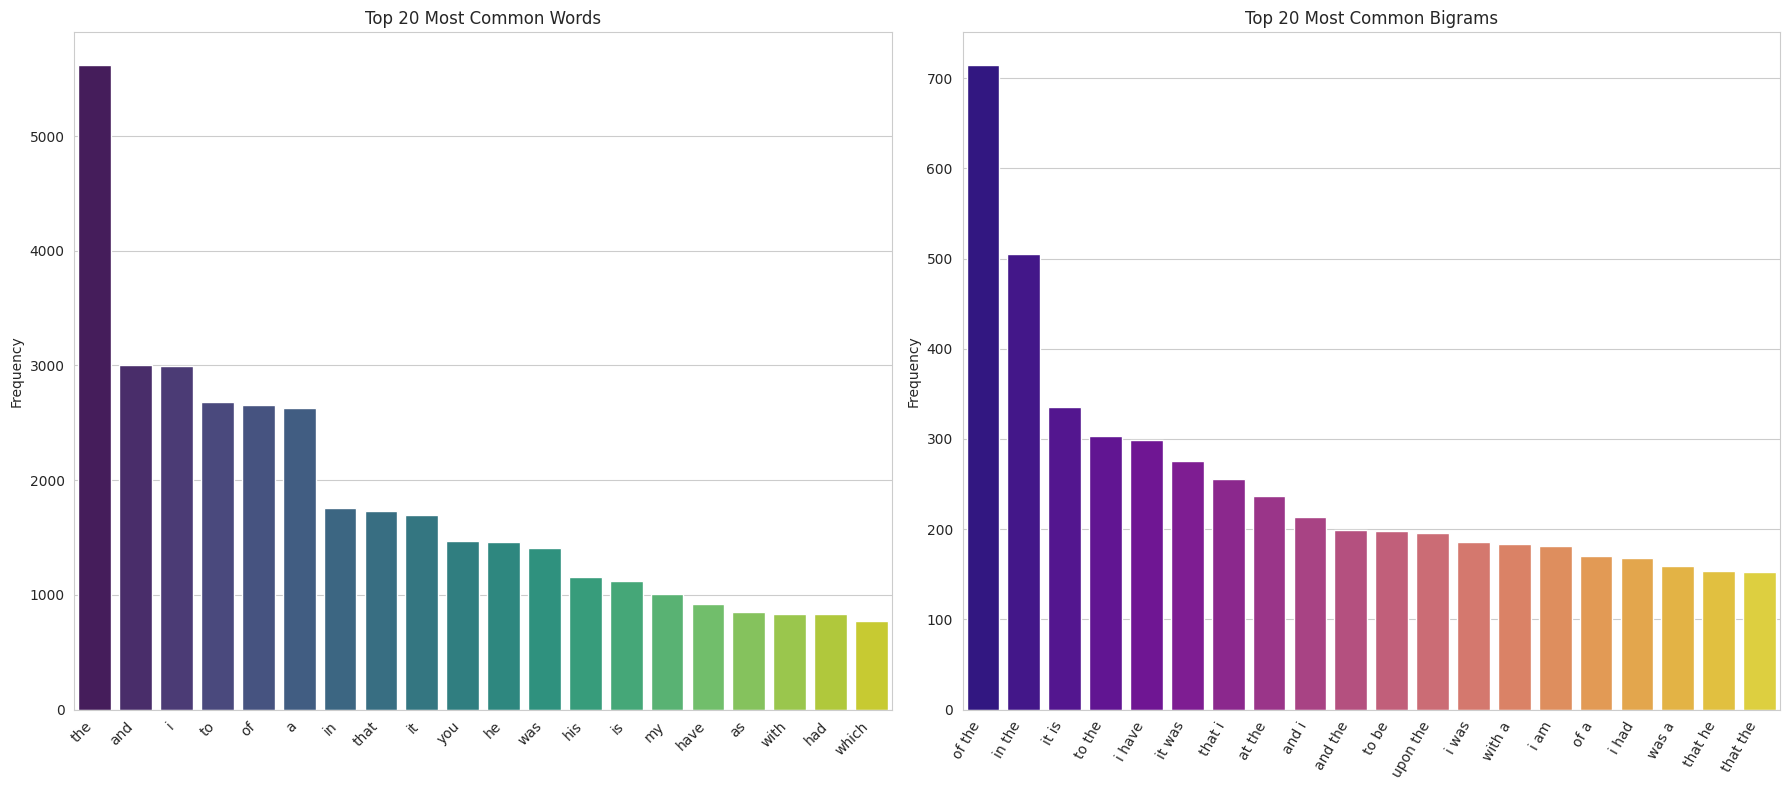

In [5]:
plt.figure(figsize=(18, 8))

# Top words plot
plt.subplot(1, 2, 1)
words_viz, counts_viz = zip(*top_20_words)
sns.barplot(x=list(words_viz), y=list(counts_viz), palette="viridis")
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45, ha="right")
plt.ylabel("Frequency")

# Bigrams plot
plt.subplot(1, 2, 2)
bigram_labels = [f"{w1} {w2}" for (w1, w2), count in common_bigrams]
bigram_counts = [count for (w1, w2), count in common_bigrams]
sns.barplot(x=bigram_labels, y=bigram_counts, palette="plasma")
plt.title('Top 20 Most Common Bigrams')
plt.xticks(rotation=60, ha="right")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 5. Preparing Training Data

Now we need to convert our long list of words into 'features' (X) and 'labels' (y) for our model. We'll use a fixed sequence length (as required, e.g., 5) to predict the next word.

Example with `SEQ_LENGTH = 5`:
* `[to, sherlock, holmes, she, is]` -> `always`
* `[sherlock, holmes, she, is, always]` -> `the`
* `[holmes, she, is, always, the]` -> `woman`

In [6]:
def create_sequences(words, seq_length=5):
    sequences = []
    next_words = []

    for i in range(len(words) - seq_length):
        # The input sequence (X)
        seq = words[i:i + seq_length]
        # The target word (y)
        next_word = words[i + seq_length]

        sequences.append(seq)
        next_words.append(next_word)

    return sequences, next_words

# Create sequences
SEQ_LENGTH = 5
sequences, next_words = create_sequences(words, SEQ_LENGTH)

print(f"Total sequences: {len(sequences)}")
print(f"Sample sequence (X): {sequences[0]}")
print(f"Sample target (y): {next_words[0]}")

Total sequences: 104402
Sample sequence (X): ['the', 'adventures', 'of', 'sherlock', 'holmes']
Sample target (y): produced


## 6. Encoding the Data

Our model needs numbers, not words. We'll use Keras' `Tokenizer` to create a word-to-index dictionary (vocabulary) and convert our sequences into integers.

We also need to split our data into training, validation, and test sets, as required by the project.

In [7]:
# Initialize and fit the tokenizer on all words to build the vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)

vocab_size = len(tokenizer.word_index) + 1 # +1 for the 0-padding
print(f"Vocabulary size: {vocab_size}")

# Convert sequences of words (X) to sequences of integers
X = tokenizer.texts_to_sequences(sequences)

# Convert target words (y) to integer labels
# We don't use texts_to_sequences here because y is not a sequence
y = np.array([tokenizer.word_index[word] for word in next_words])

# Convert X to a numpy array
X = np.array(X)

# Check shapes
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Train-validation-test split (e.g., 70% train, 15% val, 15% test)
# First split: 85% for train/val, 15% for test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Second split: Split the 85% into train and val (0.15 / 0.85 is ~17.6%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42) # 0.15 / 0.85

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Vocabulary size: 8331
Shape of X: (104402, 5)
Shape of y: (104402,)

Training samples: 73078
Validation samples: 15663
Test samples: 15661


## 7. Building the Neural Network

We will use a simple LSTM (Long Short-Term Memory) network. This type of network is well-suited for sequence data like text.

Our model will have:
1.  An **Embedding** layer: To create vector representations of words.
2.  An **LSTM** layer: To learn patterns in the sequences.
3.  **Dense** layers: To process the LSTM output.
4.  A final **Dense (softmax)** layer: To output a probability for every word in the vocabulary.

We use `sparse_categorical_crossentropy` as our loss function because our target `y` is a single integer (the index of the correct word) and not a one-hot encoded vector. This is much more memory-efficient.

In [8]:
def create_model(vocab_size, seq_length, embedding_dim=50, lstm_units=100):
    model = Sequential([
        # 1. Embedding layer
        Embedding(vocab_size, embedding_dim, input_length=seq_length),

        # 2. LSTM layer
        LSTM(lstm_units, return_sequences=False),
        Dropout(0.2),

        # 3. Dense hidden layer
        Dense(128, activation='relu'),
        Dropout(0.2),

        # 4. Output layer
        Dense(vocab_size, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy', # Use this because y is integer-encoded
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

# Create model
model = create_model(vocab_size, SEQ_LENGTH)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 8. Training the Model

It's time to train! We'll fit the model on our training data and use the validation data to monitor for overfitting.

We'll use `EarlyStopping` to stop training once the validation loss stops improving, which saves time and prevents overfitting.

*(Note: This will take a few minutes to run.)*

In [9]:
# Training parameters
EPOCHS = 20 # 50 is a lot, 20 is good for a demonstration
BATCH_SIZE = 128

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3, # Stop after 3 epochs of no improvement
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.0475 - loss: 7.0960 - val_accuracy: 0.0555 - val_loss: 6.3847
Epoch 2/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.0542 - loss: 6.2336 - val_accuracy: 0.0578 - val_loss: 6.3812
Epoch 3/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.0617 - loss: 6.0496 - val_accuracy: 0.0725 - val_loss: 6.3619
Epoch 4/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 80s 72ms/step - accuracy: 0.0765 - loss: 5.8418 - val_accuracy: 0.0922 - val_loss: 6.2983
Epoch 5/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.0961 - loss: 5.6067 - val_accuracy: 0.1032 - val_loss: 6.2886
Epoch 6/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 92s 93ms/step - accuracy: 0.1098 - loss: 5.4195 - val_accuracy: 0.1062 - val_loss: 6.3340
Epoch 7/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 47s 82ms/step - accuracy: 0.1166 - loss: 5.2815 - val_accuracy: 0.1072 - val_loss: 6.3515
Epoch 8/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.1257 - loss: 5.1507 - 

## 9. Model Evaluation

Let's see how our model performed. We'll plot the training and validation accuracy/loss to check for overfitting. Then, we'll evaluate its final performance on the unseen test set.

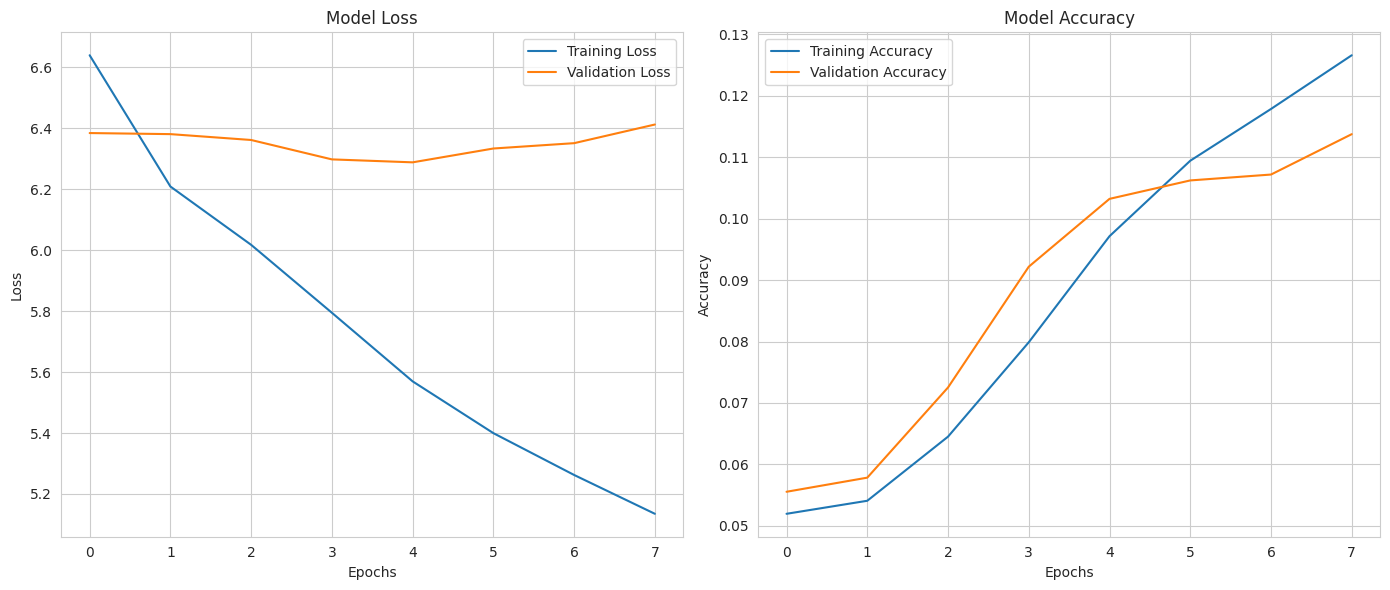


----------------------------------------
Evaluating on Test Set...
Test Loss: 6.2354
Test Accuracy: 0.1027


In [10]:
# Plot training history
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Test set evaluation
print("\n" + "-" * 40)
print("Evaluating on Test Set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## 10. Testing with Custom Input

This is the fun part! Let's write a function to give the model a sequence of words and see what it predicts. This function will:
1.  Take a string of text.
2.  Clean and preprocess it.
3.  Take the last `SEQ_LENGTH` words.
4.  Convert them to integer tokens.
5.  Feed them to the model.
6.  Get the probabilities, find the top N predictions, and convert their indexes back to words.

In [11]:
# Create a reverse mapping from index to word
index_word = {v: k for k, v in tokenizer.word_index.items()}

def predict_next_words(model, tokenizer, text, num_predictions=3):
    # Preprocess input text
    text_clean = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    text_words = text_clean.split()

    # Truncate to the last SEQ_LENGTH words
    if len(text_words) < SEQ_LENGTH:
        print(f"Error: Input text must be at least {SEQ_LENGTH} words long.")
        return []

    input_words = text_words[-SEQ_LENGTH:]

    # Convert to sequence and pad
    # Note: texts_to_sequences expects a list of texts
    sequence = tokenizer.texts_to_sequences([' '.join(input_words)])
    sequence = pad_sequences(sequence, maxlen=SEQ_LENGTH, padding='pre')

    # Get predictions
    predictions = model.predict(sequence, verbose=0)

    # Get the indices of the top N predictions
    top_indices = np.argsort(predictions[0])[-num_predictions:][::-1]

    print(f"\nInput: '{text}'")
    print(f"Top {num_predictions} predictions:")
    predicted_words = []
    for i, idx in enumerate(top_indices):
        word = index_word.get(idx, 'UNK')
        probability = predictions[0][idx]
        print(f"  {i+1}. {word} (Confidence: {probability:.2%})")
        predicted_words.append(word)

    return predicted_words

# Test examples (from Sherlock Holmes)
test_phrases = [
    "it was not that he",
    "she is always the woman",
    "i had seen little of",
    "my own complete happiness and",
    "he was pacing the room"
]

for phrase in test_phrases:
    predict_next_words(model, tokenizer, phrase, num_predictions=5)
    print("-" * 40)


Input: 'it was not that he'
Top 5 predictions:
  1. was (Confidence: 4.99%)
  2. have (Confidence: 4.05%)
  3. had (Confidence: 3.63%)
  4. is (Confidence: 3.35%)
  5. would (Confidence: 1.97%)
----------------------------------------

Input: 'she is always the woman'
Top 5 predictions:
  1. and (Confidence: 4.66%)
  2. of (Confidence: 4.10%)
  3. i (Confidence: 3.51%)
  4. was (Confidence: 3.13%)
  5. is (Confidence: 2.90%)
----------------------------------------

Input: 'i had seen little of'
Top 5 predictions:
  1. the (Confidence: 10.09%)
  2. a (Confidence: 6.44%)
  3. his (Confidence: 2.66%)
  4. my (Confidence: 2.11%)
  5. it (Confidence: 1.76%)
----------------------------------------

Input: 'my own complete happiness and'
Top 5 predictions:
  1. the (Confidence: 1.11%)
  2. a (Confidence: 0.93%)
  3. i (Confidence: 0.92%)
  4. and (Confidence: 0.77%)
  5. in (Confidence: 0.67%)
----------------------------------------

Input: 'he was pacing the room'
Top 5 predictions:
  1.

## 11. Experimentation and Next Steps

This is a simple model, but it demonstrates the core concept and fulfills the project requirements. To improve it, we could:

* **Use a larger corpus:** More data (e.g., more books) would lead to a richer vocabulary and better predictions.
* **Tune Hyperparameters:** Experiment with `SEQ_LENGTH`, `embedding_dim`, `lstm_units`, `BATCH_SIZE`, and `EPOCHS`.
* **Build a Deeper Model:** Stack multiple LSTM layers (remembering to use `return_sequences=True` on all but the last LSTM layer).
* **Use Pre-trained Embeddings:** Use transfer learning with pre-trained word embeddings like GloVe or Word2Vec.

In [12]:
# Example of a deeper model architecture (as shown in the guide)
def create_deep_model(vocab_size, seq_length):
    model = Sequential([
        Embedding(vocab_size, 100, input_length=SEQ_LENGTH),
        LSTM(150, return_sequences=True), # Returns a sequence for the next LSTM
        Dropout(0.2),
        LSTM(100), # This one does not return sequences
        Dropout(0.2),
        Dense(100, activation='relu'),
        Dense(vocab_size, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

print("Example of a deeper model architecture:")
deep_model = create_deep_model(vocab_size, SEQ_LENGTH)
deep_model.summary()

Example of a deeper model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## ✅ Project Complete

This notebook successfully implements all the requirements for the Next Word Prediction project, from data cleaning and EDA to model building, training, and testing.